<a href="https://colab.research.google.com/github/AkiraMarques/MLP-Iris-fisher/blob/main/Tarefa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# importando bibliotecas
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris # dataset Fisher Iris

In [101]:
# dados

# importando dados com pandas
'''
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
df = pd.read_csv(url)
'''

iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# Assumindo que a última coluna é a label
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values.reshape(-1, 1)  # Labels

# Normalizar as features
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Garantir que as labels estão no formato correto
y = y.astype(int)

In [102]:
# função para One-Hot Encoding manual para classificar as 3 classes
def one_hot_encode(y, num_classes):
  one_hot = np.zeros((y.shape[0], num_classes))
  one_hot[np.arange(y.shape[0]), y.flatten()] = 1
  return one_hot

# aplicando o one-hot encoding
y = one_hot_encode(y, 3)

In [103]:
# função para dividir dados em treino, validação e teste
def div_dados(X, y, tam_treino=0.5, tam_val=0.3, tam_teste=0.2): # como padrão deixei tam de treino, validação e teste como 50%, 30% e 20% respectivamente
  # misturando os dados
  indices = np.arange(X.shape[0])
  np.random.seed(90)
  np.random.shuffle(indices)

  X = X[indices]
  y = y[indices]

  # Determinar os tamanhos dos conjuntos
  fim_treino = int(tam_treino * X.shape[0])
  fim_val = fim_treino + int(tam_val * X.shape[0])

  # Divisão dos dados
  X_treino, X_val, X_teste = X[:fim_treino], X[fim_treino:fim_val], X[fim_val:]
  y_treino, y_val, y_teste = y[:fim_treino], y[fim_treino:fim_val], y[fim_val:]

  return X_treino, X_val, X_teste, y_treino, y_val, y_teste

In [104]:
# criando objeto MLP e suas funções
class MLP:
  def __init__(self, input_size, hidden_size, output_size, taxa_aprendizado=0.1):
    self.taxa_aprendizado = taxa_aprendizado
    # iniciando pesos com valores iguais a zero
    self.w_input_hidden = np.zeros((input_size, hidden_size)) # pesos das entradas para as camadas ocultas
    self.w_hidden_output = np.zeros((hidden_size, output_size)) # pesos das camadas ocultas para as saídas

    # iniciando os bias com zeros
    self.bias_hidden = np.zeros((1, hidden_size)) # bias das camadas ocultas
    self.bias_output = np.zeros((1, output_size)) # bias das saídas

  def feedforward(self, X):
    # camada oculta
    self.hidden_input = np.dot(X, self.w_input_hidden) + self.bias_hidden
    self.hidden_output = sigmoid(self.hidden_input)

    # camada de saída
    self.final_input = np.dot(self.hidden_output, self.w_hidden_output) + self.bias_output
    self.final_output = softmax(self.final_input)

    return self.final_output

  def backpropagation(self, X, y_real):
    # forward
    y_prev = self.feedforward(X)

    # calculando erro da camada de saída
    erro_camada_saida = y_real - y_prev

    # gradiente da camada de saída
    grad_saida = erro_camada_saida

    # erro camada oculta
    erro_camada_hidden = grad_saida.dot(self.w_hidden_output.T)
    grad_hidden = erro_camada_hidden * deriv_sigmoid(self.hidden_output)

    # atualizando pesos e bias
    self.w_input_hidden += self.taxa_aprendizado * np.dot(X.T, grad_hidden)
    self.bias_hidden += self.taxa_aprendizado * np.sum(grad_hidden, axis=0, keepdims=True)

    self.w_hidden_output += self.taxa_aprendizado * np.dot(self.hidden_output.T, grad_saida)
    self.bias_output += self.taxa_aprendizado * np.sum(grad_saida, axis=0, keepdims=True)

  def train(self, X_treino, y_treino, X_val=None, y_val=None, epochs=1000):
    for e in range(epochs):
      # Embaralhar dados de treinamento
      indices = np.arange(X_treino.shape[0])
      np.random.shuffle(indices)
      X_treino = X_treino[indices]
      y_treino = y_treino[indices]

      # forward e backpropagation
      self.backpropagation(X_treino, y_treino)

      if e % 100 == 0:
        # calculando perda nos dados de treinamento
        y_prev_treino = self.feedforward(X_treino)
        perda_treino = mse_perda(y_treino, y_prev_treino)

        if X_val is not None and y_val is not None:
          # calculando perda nos dados de validação, se os mesmos existirem
          y_prev_val = self.feedforward(X_val)
          perda_val = mse_perda(y_val, y_prev_val)
          print(f'Epoch: {e}, Perda no treino: {perda_treino:.4f}, Perda na validação: {perda_val:.4f}')
        else:
          print(f'Epoch: {e}, Perda no treino: {perda_treino:.4f}')

  def predict(self, X):
    y_prev = self.feedforward(X)
    # converter probabilidades em classes
    return np.argmax(y_prev, axis=1) # retorna a classe com a maior probabilidade

# função de ativação sigmoidal
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# derivada da função segmoidal
def deriv_sigmoid(x):
  return x * (1 - x)

# função softmax para múltiplas classes
def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# função de custo (perda) -> Erro quadrático médio (Mean Squared Error - MSE)
# função boa para utilização em problemas de regressão
def mse_perda(y_real, y_prev):
  return np.mean((y_real - y_prev) ** 2)


In [105]:
# dividindo dados e criando um MLP

# dividindo os dados de treino, validação e teste
X_treino, X_val, X_teste, y_treino, y_val, y_teste = div_dados(X, y)

# criando o MLP
input_size = X.shape[1]
hidden_size = 50
output_size = 3 # agora temos 3 classes no dataset
mlp = MLP(input_size, hidden_size, output_size, 0.1)

In [106]:
# treinando o MLP
mlp.train(X_treino, y_treino, X_val, y_val, epochs=10000)

Epoch: 0, Perda no treino: 0.3999, Perda na validação: 0.4888
Epoch: 100, Perda no treino: 0.0256, Perda na validação: 0.0503
Epoch: 200, Perda no treino: 0.0151, Perda na validação: 0.0297
Epoch: 300, Perda no treino: 0.0122, Perda na validação: 0.0207
Epoch: 400, Perda no treino: 0.0112, Perda na validação: 0.0166
Epoch: 500, Perda no treino: 0.0107, Perda na validação: 0.0151
Epoch: 600, Perda no treino: 0.0104, Perda na validação: 0.0149
Epoch: 700, Perda no treino: 0.0102, Perda na validação: 0.0155
Epoch: 800, Perda no treino: 0.0100, Perda na validação: 0.0166
Epoch: 900, Perda no treino: 0.0098, Perda na validação: 0.0179
Epoch: 1000, Perda no treino: 0.0097, Perda na validação: 0.0195
Epoch: 1100, Perda no treino: 0.0096, Perda na validação: 0.0212
Epoch: 1200, Perda no treino: 0.0094, Perda na validação: 0.0230
Epoch: 1300, Perda no treino: 0.0093, Perda na validação: 0.0248
Epoch: 1400, Perda no treino: 0.0092, Perda na validação: 0.0266
Epoch: 1500, Perda no treino: 0.0091,

In [107]:
# testando o MLP
y_prev_teste = mlp.predict(X_teste)

# convertendo as labels de volta para o formato original (não one-hot)
y_teste_real = np.argmax(y_teste, axis=1)

# imprimindo previsões
for i in range(len(X_teste)):
        print(f"Entrada: {X_teste[i]}, Predito: {y_prev_teste[i]}, Real: {y_teste_real[i]}")

Entrada: [0.11111111 0.5        0.05084746 0.04166667], Predito: 0, Real: 0
Entrada: [0.36111111 0.41666667 0.59322034 0.58333333], Predito: 1, Real: 1
Entrada: [0.30555556 0.58333333 0.08474576 0.125     ], Predito: 0, Real: 0
Entrada: [0.41666667 0.83333333 0.03389831 0.04166667], Predito: 0, Real: 0
Entrada: [0.52777778 0.375      0.55932203 0.5       ], Predito: 1, Real: 1
Entrada: [0.41666667 0.29166667 0.69491525 0.75      ], Predito: 2, Real: 2
Entrada: [0.38888889 0.25       0.42372881 0.375     ], Predito: 1, Real: 1
Entrada: [0.72222222 0.45833333 0.69491525 0.91666667], Predito: 2, Real: 2
Entrada: [0.63888889 0.41666667 0.57627119 0.54166667], Predito: 1, Real: 1
Entrada: [0.44444444 0.5        0.6440678  0.70833333], Predito: 2, Real: 1
Entrada: [0.27777778 0.70833333 0.08474576 0.04166667], Predito: 0, Real: 0
Entrada: [0.16666667 0.45833333 0.08474576 0.        ], Predito: 0, Real: 0
Entrada: [0.19444444 0.58333333 0.10169492 0.125     ], Predito: 0, Real: 0
Entrada: [0.

In [108]:
# calculando acurácia, precisão e revocação usando sklearn

# importando do sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convertendo one-hot encoding de volta para rótulos de classes
y_teste_labels = np.argmax(y_teste, axis=1)

# calculando a acurácia
acuracia = accuracy_score(y_teste_labels, y_prev_teste)
print(f'Acurácia: {acuracia * 100}%')

# calculando a precisão (média macro para lidar com classes balanceadas)
precisao = precision_score(y_teste_labels, y_prev_teste, average='macro')
print(f'Precisão (macro): {precisao * 100:.2f}%')

# calculando a revocação (média macro)
revocacao = recall_score(y_teste_labels, y_prev_teste, average='macro')
print(f'Revocação (macro): {revocacao * 100:.2f}%')

Acurácia: 96.66666666666667%
Precisão (macro): 96.30%
Revocação (macro): 96.97%


In [109]:
# calculo da matriz de confusão para avaliar desempenho do modelo

# importando matriz de confusão e relatório de classificação do sklearn
from sklearn.metrics import confusion_matrix, classification_report

# Convertendo one-hot encoding de volta para rótulos de classes
y_teste_labels = np.argmax(y_teste, axis=1)

# Imprimindo a matriz de confusão
cm = confusion_matrix(y_teste_labels, y_prev_teste)
print("\nMatriz de Confusão:")
print(cm)

# Imprimindo o relatório de classificação com precisão, recall e F1-score
print("\nRelatório de Classificação:")
print(classification_report(y_teste_labels, y_prev_teste))



Matriz de Confusão:
[[11  0  0]
 [ 0 10  1]
 [ 0  0  8]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.91      0.95        11
           2       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



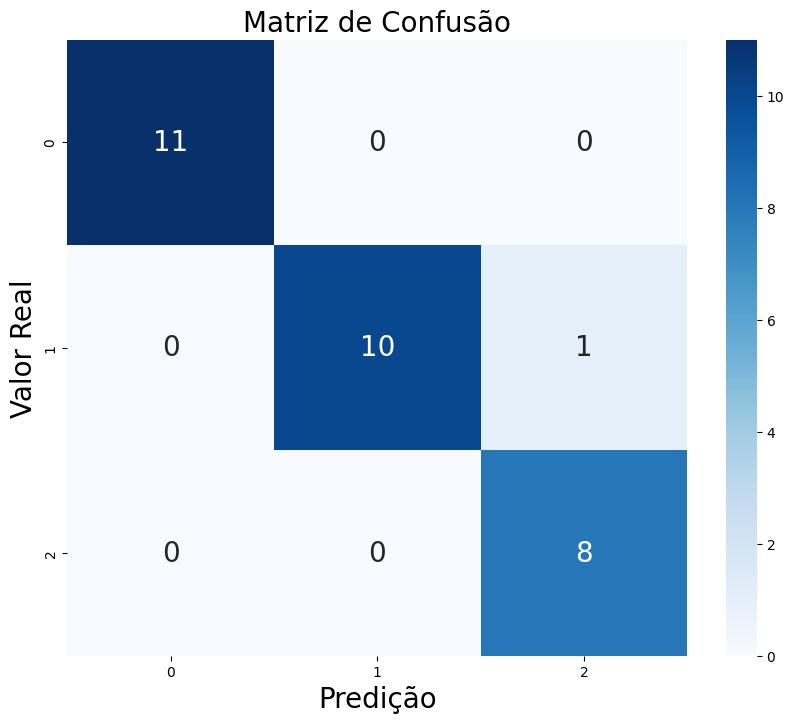

In [110]:
# demonstrando graficamente a matriz de confusão

# importando matplotlib e seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# plotando matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 20})  # Aumenta o tamanho da fonte das anotações
plt.xlabel('Predição', fontsize=20)
plt.ylabel('Valor Real', fontsize=20)
plt.title('Matriz de Confusão', fontsize=20)
plt.show()